In [55]:
%load_ext autoreload
%autoreload 2
from evolution_algos import cem_uncorrelated, saes_1_1, ObjectiveFunction
from evolution_policy import NeuralNetworkPolicy, LogisticRegression

import numpy as np
from test_utils import RenderWrapper
from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.persistence import RailEnvPersister
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import SparseRailGen
# from flatland_cutils import TreeObsForRailEnv as TreeCutils
from flatland.envs.observations import GlobalObsForRailEnv

from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.distance_map import DistanceMap
import flatland.envs.rail_env_shortest_paths as sp

from flatland.utils.rendertools import RenderTool

from observation_utils import normalize_observation

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Create the environment
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

In [57]:
# Initializing policy
n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes
policy = LogisticRegression(state_size, 5)
print(policy.num_params)

1155


In [4]:
# test on one step

theta = np.random.rand(policy.num_params)

obs, info = env.reset()
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
actions = {}
for agent in env.get_agent_handles():
    actions[agent] = policy.act(agent_obs[agent], theta)

obs, all_rewards, done, _ = env.step(actions)

print(all_rewards)
    

{0: 0, 1: 0}


In [54]:
# get average result on 10 runs (used to tune parameters of the model)

for i in range(10):
    # Cross entropy method

    # Create the objective function
    objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=1 , max_time_steps=200)

    init_mean_array = np.random.random(size = policy.num_params)
    init_var_array = np.ones(shape=policy.num_params) * 100.
    hist_dict = {}
    cem = cem_uncorrelated(
        objective_function,
        mean_array = init_mean_array,
        var_array = init_var_array,
        max_iterations=50,
        sample_size=50,
        elite_frac=0.3,
        print_every=5,
        success_score=15,
        hist_dict=hist_dict
    )

iteration :  0
sorted samples :  [19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 21.0, 23.0, 24.0, 24.0, 26.0, 26.0, 28.0, 29.0, 30.0, 32.0, 34.0, 34.0, 35.0, 36.0, 36.0, 36.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 40.0, 41.0, 42.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 49.0, 52.0, 58.0, 58.0]
36.44
iteration :  5
sorted samples :  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 7.0, 7.0, 15.0, 16.0, 21.0, 23.0, 27.0, 27.0, 28.0, 28.0, 28.0, 30.0, 31.0, 39.0, 40.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 42.0, 42.0, 42.0, 45.0, 45.0]
17.32
iteration :  10
sorted samples :  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 27.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 29.0, 30.0, 30.0, 31.0, 39.0, 40.0, 41.0, 41.0, 41.0, 42.0, 43.0, 43.0, 43.0, 44.0, 44.0,

In [8]:
## One run only
# Cross entropy method

# Create the objective function
objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=1 , max_time_steps=200)

init_mean_array = np.random.random(size = policy.num_params)
init_var_array = np.ones(shape=policy.num_params) * 100.
hist_dict = {}
theta = cem_uncorrelated(
    objective_function,
    mean_array = init_mean_array,
    var_array = init_var_array,
    max_iterations=50,
    sample_size = 50,
    elite_frac=0.1,
    print_every=5,
    success_score=15,
    hist_dict=hist_dict
)

iteration :  0
sorted samples :  [-0.0, 16.0, 18.0, 19.0, 20.0, 20.0, 21.0, 21.0, 23.0, 23.0, 23.0, 23.0, 27.0, 28.0, 28.0, 29.0, 30.0, 33.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 39.0, 40.0, 41.0, 41.0, 41.0, 42.0, 42.0, 43.0, 44.0, 45.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 53.0, 53.0, 54.0, 55.0]
36.02
iteration :  5
sorted samples :  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 27.0, 28.0, 28.0, 28.0, 29.0, 29.0, 29.0, 29.0, 30.0, 31.0, 32.0, 39.0, 39.0, 41.0, 41.0, 41.0, 42.0, 42.0, 42.0, 42.0, 43.0, 43.0, 44.0, 44.0, 44.0, 44.0]
19.02
iteration :  10
sorted samples :  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 27.0, 27.0, 27.0, 28.0, 28.0, 30.0, 30.0, 30.0, 30.0, 31.0, 31.0, 31.0, 31.0, 31.0, 32.0, 32.0, 39.0, 41.0, 41.0, 41.0, 41.0, 42.0, 43.0, 44.

In [59]:
# 10 runs of SAES 1+1 to compare with CEM (used to tune parameters of the model)

for i in range(10):

    hist_dict = {}

    init_x_array = np.random.random(size = policy.num_params)
    init_sigma_array = np.ones(shape=policy.num_params) * 100.



    objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=2 , max_time_steps=200)

    saes = saes_1_1(
        objective_function,
        x_array = init_x_array,
        sigma_array = init_sigma_array,
        tau = 0.01,
        max_iterations=100,
        print_every=1,
        success_score=10,
        hist_dict=hist_dict
    )

Iteration 0/100: Score = 28.5
Iteration 1/100: Score = 38.5
Iteration 2/100: Score = 34.0
Iteration 3/100: Score = 34.5
Iteration 4/100: Score = 25.5
Iteration 5/100: Score = 42.5
Iteration 6/100: Score = 33.0
Iteration 7/100: Score = 31.0
Iteration 8/100: Score = 24.5
Iteration 9/100: Score = -0.0
Success after 9 iterations!
Iteration 0/100: Score = 28.0
Iteration 1/100: Score = 48.5
Iteration 2/100: Score = 42.0
Iteration 3/100: Score = 39.0
Iteration 4/100: Score = 31.0
Iteration 5/100: Score = 38.0
Iteration 6/100: Score = 29.0
Iteration 7/100: Score = 29.5
Iteration 8/100: Score = 28.5
Iteration 9/100: Score = 29.5
Iteration 10/100: Score = 30.0
Iteration 11/100: Score = 18.0
Iteration 12/100: Score = 15.0
Iteration 13/100: Score = 27.0
Iteration 14/100: Score = 22.0
Iteration 15/100: Score = 24.5
Iteration 16/100: Score = 21.5
Iteration 17/100: Score = 21.5
Iteration 18/100: Score = 23.5
Iteration 19/100: Score = 25.0
Iteration 20/100: Score = 23.5
Iteration 21/100: Score = 22.0


In [6]:
# print algorithm final parameters
saes

array([190.33375314, 190.68133633, 191.06693956, 190.80756985,
       191.18520666, 190.26972423, 191.02983619, 190.72558056,
       190.90024534, 190.66276819, 191.16792731, 190.41626455,
       190.99629567, 190.59299004, 190.64557841, 190.38203   ,
       190.97200149, 190.26754572, 190.80874985, 190.6207044 ,
       190.69363154, 190.45142581, 190.71215622, 190.3801599 ,
       190.39662143, 190.53583828, 190.63002011, 190.69443982,
       190.65563278, 190.45810012, 191.1327351 , 190.30212169,
       190.98731476, 190.69617498, 190.28788239, 191.0232823 ,
       190.69021476, 190.6181391 , 190.29788784, 190.60634319,
       190.7064484 , 191.06517829, 191.23039566, 191.19785585,
       190.36372497, 190.92881212, 190.58781164, 190.6593845 ,
       190.98741183, 191.17884637, 190.76764305, 190.62035647,
       190.54082329, 190.85816821, 190.28695992, 190.41582755,
       190.69174242, 190.66811626, 190.43000513, 191.22392654,
       190.87792146, 190.70253611, 190.36904598, 190.77

In [15]:
# show reward on a few episodes

for i in range(5):
    print(objective_function(saes))

28.5
-0.0
22.0
-0.0
19.5


In [24]:
## visualization of the environment and the policy

# Create the environment
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

In [25]:
# Initializing policy
n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes
policy = LogisticRegression(state_size, 5)
print(policy.num_params)

1155


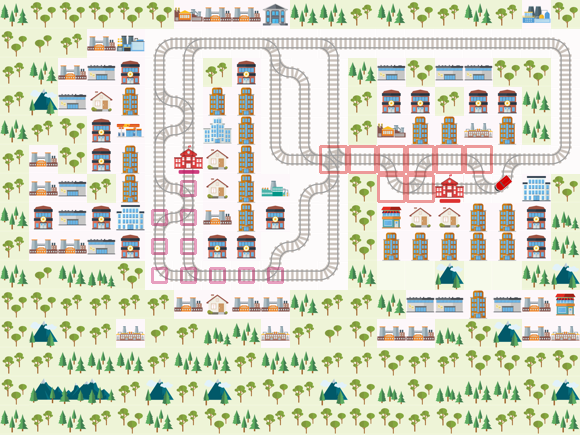

Stopped at time step  28
{0: 0, 1: 0}


In [32]:


state, info = env.reset()
env_renderer = RenderWrapper(env,real_time_render=True, force_gif=False)

max_time_steps = 500

for t in range(max_time_steps):
    env_renderer.render()
    time.sleep(0.2)
    
    agent_obs = [None] * env.get_num_agents()
    for agent in env.get_agent_handles():
        if state[agent]:
            agent_obs[agent] = normalize_observation(state[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
    actions = {}
    for agent in env.get_agent_handles():
        actions[agent] = policy.act(agent_obs[agent], cem)
    
    state, all_rewards, done, info = env.step(actions)
    #print("step : ", t)
    #print("rewards : ", all_rewards)
    #print("actions : ", actions)
    #total_rewards += sum(all_rewards.values())

    if done['__all__']:
        print("Stopped at time step ", t)
        print(all_rewards)
        break

In [43]:
## Neural Network Policy

# Create the environment
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

In [44]:
# Initializing nn policy
n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes
n_actions = 5
nn_policy = NeuralNetworkPolicy(state_size, n_actions, 32)
print(nn_policy.num_params)

Number of parameters per layer: [(232, 32), (33, 5)]
Number of parameters (neural network weights) to optimize: 7589
7589


In [49]:
# Cross entropy method

# Create the objective function
objective_function = ObjectiveFunction(env, policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=1 , max_time_steps=200)

init_mean_array = np.random.random(size = policy.num_params)
init_var_array = np.ones(shape=policy.num_params) * 1000.
hist_dict = {}
theta = cem_uncorrelated(
    objective_function,
    mean_array = init_mean_array,
    var_array = init_var_array,
    max_iterations=50,
    sample_size = 50,
    elite_frac=0.1,
    print_every=5,
    success_score=15,
    hist_dict=hist_dict
)

(231,) (11, 32)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 231)

In [47]:
hist_dict = {}

init_x_array = np.random.random(size = policy.num_params)
init_sigma_array = np.ones(shape=policy.num_params) * 1.



objective_function = ObjectiveFunction(env, nn_policy,observation_tree_depth=observation_tree_depth, observation_radius=observation_radius, num_episodes=2 , max_time_steps=200)

saes = saes_1_1(
    objective_function,
    x_array = init_x_array,
    sigma_array = init_sigma_array,
    tau = 0.001,
    max_iterations=100,
    print_every=5,
    success_score=10,
    hist_dict=hist_dict
)

ValueError: cannot reshape array of size 549 into shape (232,32)